In [1]:
import pandas as pd
import re
import importlib
import tld
import nltk
import csv
import collections
import itertools
import sys
import historical.util as util
import historical.ioutils as ioutils

import matplotlib.pyplot as plt

In [2]:
stopwords = set(nltk.corpus.stopwords.words('english'))
punct_re = re.compile(r"[\,\?\|\(\)•\*\:';“”\#" + r'\"' + r"]")

In [3]:
#We need to initialize util
import argparse
parse = argparse.ArgumentParser()
util.add_arguments(parse)
#--use-sample for faster, lower memory tests, although things are pretty fast as-is
#args = parse.parse_args(args=["--use-sample"])
args = parse.parse_args(args=[])
util.process_arguments(args)

In [18]:
#Load the data
import pickle
with open("../data/deduped_policy_text_v11no_html_with_links_and_emails.pickle", "rb") as f:
    df = pickle.load(f)
    
df = df[df.year_season == "2019_B"]

108499


23888

In [5]:
li_re_str = r"legitimate\s(?:business\s)?(?:purpose|interest)"
df_li = df[df.policy_text.str.contains(li_re_str,regex=True,case=False,na=False)]

In [6]:
import re
li_re = re.compile(li_re_str,flags=re.I)
def extract_li(text,before_ct=5,after_ct=5):
    keep = []
    before = collections.deque([],before_ct)
    to_keep = 0
    for sent in nltk.tokenize.sent_tokenize(text):
        
        if to_keep != 0:
            keep.append(sent)
            to_keep -= 1
            continue
             
        if li_re.search(sent):
            to_keep = after_ct
            keep += list(before)
            keep.append(sent)
            before = collections.deque([],before_ct)
        else:
            before.append(sent)
            
    return " ".join(keep)

df_li["li_text"] = df_li.policy_text.apply(extract_li,before_ct=0,after_ct=3)

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
def get_ngrams(text,n=1):
    phrase_gens = []
    for sent in nltk.tokenize.sent_tokenize(text):
        sent = re.sub(punct_re, "", sent.lower())
        word_list = nltk.tokenize.word_tokenize(sent)
        word_list = filter(lambda w: any((c.isalpha() for c in w)), word_list)
        word_list = filter(lambda w: w not in stopwords, word_list)
        #word_list = [sys.intern(w) for w in word_list]
        phrase_gens.append((" ".join(l) for l in nltk.ngrams(word_list, n)))
    phrases = itertools.chain.from_iterable(phrase_gens)
    return phrases

In [8]:
df_s = df.sample(100)
df_li_s = df_li.sample(10)
df_s = pd.concat((df_s,df_li_s))

In [46]:
fds = {}
for n in [1,2,3]:
    grams = itertools.chain.from_iterable((get_ngrams(t,n=n) for t in df.policy_text))
    fds[n] = nltk.probability.FreqDist(grams)

In [47]:
li_fds = {}
for n in [1,2,3]:
    grams = itertools.chain.from_iterable((get_ngrams(t,n=n) for t in df_li.li_text))
    li_fds[n] = nltk.probability.FreqDist(grams)

In [35]:
len(df_li)

6146

In [58]:
thresh = 61
blacklist = ["legitimate","purpose","interest"]
for n in [1,2,3]:
    to_remove = []
    for sample, ct in li_fds[n].most_common(li_fds[n].B()):
        if ct <= thresh or any((b in sample for b in blacklist)):
            to_remove.append(sample)
            
    for sample in to_remove:
        del li_fds[n][sample]

In [68]:
def get_dfdf(fdist1,fdist2):
    dfdf = nltk.probability.FreqDist()
    for sample,ct in fdist1.most_common(fdist1.B()):
        try:
            dfdf[sample] = fdist1[sample] / fdist2[sample]
        except ZeroDivisionError:
            print("Zero Division on: %s" % sample)
            print("%s/%s" % (fdist1[sample], fdist2[sample]))
            #return None
    return dfdf

dfdfs = {
    n: get_dfdf(li_fds[n],fds[n]) for n in [1,2,3]
}

In [64]:
def print_grams(n):
    for sample,ct in dfdfs[n].most_common(50):
        print("%0.5f\t%s" % (ct,sample))
    

In [65]:
print_grams(1)

0.97642	overridden
0.94253	service/product
0.92118	pursued
0.82339	61f
0.81679	outweighed
0.78082	vested
0.77387	grow
0.77301	outweigh
0.75870	fundamental
0.75728	balanced
0.74848	impacts
0.74265	satisfies
0.72152	partake
0.72068	freedoms
0.70182	override
0.67637	compelling
0.66720	strategy
0.65440	products/services
0.64090	ground
0.62338	justify
0.60406	pursuing
0.59426	balancing
0.59048	detrimental
0.58537	pursuit
0.58007	namely
0.54167	proportionate
0.51639	assertion
0.50932	exponential
0.50798	relying
0.49627	reorganisation
0.49117	necessity
0.48428	strengthen
0.48418	jimdo
0.45796	recover
0.45734	justification
0.44746	debts
0.44411	balance
0.43976	jeopardize
0.43849	pursue
0.42079	vital
0.41710	shorter
0.39706	obligatory
0.39042	task
0.37803	promoting
0.37053	study
0.36674	rely
0.36090	justified
0.35669	radisson
0.35486	bases
0.35340	grounds


In [66]:
print_grams(2)

1.00000	namely proper
1.00000	situation makes
1.00000	party something
1.00000	impact positive
1.00000	negative rights
1.00000	sure consider
1.00000	pursued owner
1.00000	resident note
1.00000	products/services grow
1.00000	develop products/services
1.00000	namely monitoring
1.00000	strategy use
1.00000	best service/product
1.00000	vested owner
1.00000	freedoms require
1.00000	service/product best
1.00000	individual valid
0.99592	something particular
0.99526	communications performance
0.99448	ground feel
0.99435	technical necessary
0.99419	including basis
0.99317	rights override
0.99213	updated study
0.99194	makes want
0.99174	pursued us
0.99167	survey identity
0.99160	61f general
0.98958	impact respect
0.98901	consider balance
0.98901	balance potential
0.98851	technical b
0.98837	strategy make
0.98765	e profile
0.98718	exercise b
0.98529	products/services develop
0.98485	law vital
0.98206	usage e
0.98026	define types
0.97890	data relying
0.97778	fraud context
0.97674	experiences techni

In [67]:
print_grams(3)

1.00000	fundamental rights override
1.00000	contract b necessary
1.00000	something particular situation
1.00000	situation makes want
1.00000	particular situation makes
1.00000	namely proper administration
1.00000	third party something
1.00000	party something particular
1.00000	communications performance contract
1.00000	marketing communications performance
1.00000	user information processing
1.00000	ground feel impacts
1.00000	processing including basis
1.00000	potential impact positive
1.00000	impact positive negative
1.00000	positive negative rights
1.00000	make sure consider
1.00000	sure consider balance
1.00000	negative rights process
1.00000	resident note processing
1.00000	additionally european resident
1.00000	european resident note
1.00000	site otherwise pursue
1.00000	managing business enable
1.00000	make order site
1.00000	order site otherwise
1.00000	products/services grow business
1.00000	overridden rights payment
1.00000	rights payment processing
1.00000	develop products/s

In [16]:
%%script false --no-raise-error

with open("out/legitimate_interest.csv", "w+") as f:
    w = csv.writer(f)
    w.writerow(["site_url","year_season","homepage_snapshot_url","policy_text","distance"])
    for index, row in df_li.sample(100).iterrows():
        extracted_text = extract_li(row["policy_text"])
        w.writerow([row["site_url"],row["year_season"],row["homepage_snapshot_url"],row["policy_snapshot_url"]])

In [17]:
%%script false --no-raise-error

def load_grams(n,limit=None,search_for=None,recount=False,domain_norm_factor=None,policy_norm_factor=None):
    util.get_blacklist() #Ensure this is loaded first

    def queue_grams(n,yearseas,limit,search_for):
        for row in ioutils.load_grams(n,yearseas,limit=limit):
            if search_for is not None:
                s=row[1]
                if s not in search_for:
                    continue

            if recount:
                counts = {}
                doms = row[2:]
                for count_name, (countf, count_friendly_name) in util.count_fxns.items():
                    counts[count_name] = countf(doms,yearseason=yearseas,domain_norm_factor=domain_norm_factor,policy_norm_factor=policy_norm_factor)
                row = (counts, *row[1:])
            yield((yearseas,row))

    for yearseas in util.iter_yearseason():
        yield from queue_grams(n,yearseas,limit,search_for)


try:
    fds = {}
    for i in [1,2,3]:
        fd = nltk.probability.FreqDist()
        fds[i] = fd
        for _,(ct,phrase,*_) in load_grams(n=i):
            fd[phrase] += ct
except:
    sys.err.write("Failed, moving to backup\n")
    #grams = {i:itertools.chain.from_iterable((get_ngrams(t,n=i) for t in df.policy_text)) for i in [1,2,3]}
    grams = {
        1:itertools.chain.from_iterable((get_ngrams(t,n=1) for t in df.policy_text)),
        2:itertools.chain.from_iterable((get_ngrams(t,n=1) for t in df.policy_text)),
        3:itertools.chain.from_iterable((get_ngrams(t,n=1) for t in df.policy_text))
    }
    fds = {i:nltk.probability.FreqDist(grams[i]) for i in grams}

In [18]:
%%script false --no-raise-error

def extract_li(text,before_ct=1000,after_ct=1000):
    ret = ""
    idx = 0
    
    start_old = 0
    end_old = 0
    
    while True:
        try:
            idx = text.lower().index("legitimate interest",idx+1)
            start = max(0,idx-before_ct)
            end = min(len(text) - 1, idx+after_ct)
            
            if start <= end_old:
                start = start_old
            elif end_old != 0:
                ret += text[start_old:end_old] + "\n" + "="*60 + "\n"
            
            start_old = start
            end_old = end
            
        except ValueError:
            if end_old != 0:
                ret += text[start_old:end_old] + "\n" + "="*60 + "\n"
            break
    return ret

# Trends

In [9]:
try:
    cache = nb_trending.cache
    importlib.reload(nb_trending)
    nb_trending.cache = cache
except NameError:
    import nb_trending

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


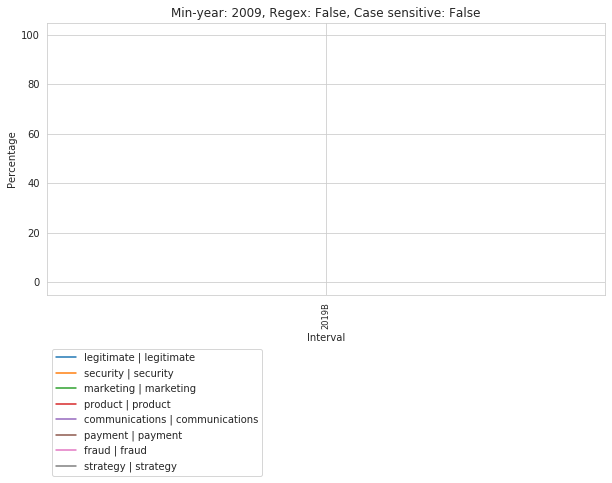

In [13]:
terms = [
    "legitimate", "strategy", "fraud", "marketing", "communications", "security", "payment", "product"
]
labels = terms

df_li.policy_text = df_li.li_text

nb_trending.plot_terms(df_li,terms,labels=labels,regex=False,case=False,save_figure=False)